<a href="https://colab.research.google.com/github/ab3131/NBAInjuryPredictor/blob/main/NBAInjuryPredictorAdvanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Import Statements**

In [180]:
!pip install opendatasets

In [296]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 9.1 MB/s eta 0:00:00


In [181]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import opendatasets as od

# **Data Cleaning**

In [182]:
od.download("https://www.kaggle.com/datasets/sumitrodatta/nba-aba-baa-stats?select=Player+Per+Game.csv")
od.download("https://www.kaggle.com/datasets/loganlauton/nba-injury-stats-1951-2023")

Skipping, found downloaded files in "./nba-aba-baa-stats" (use force=True to force download)
Skipping, found downloaded files in "./nba-injury-stats-1951-2023" (use force=True to force download)


In [183]:
player_stats = pd.read_csv("/content/nba-aba-baa-stats/Player Per Game.csv")
player_stats_advanced = pd.read_csv("/content/nba-aba-baa-stats/Advanced.csv")
injuries_original = pd.read_csv("/content/nba-injury-stats-1951-2023/NBA Player Injury Stats(1951 - 2023).csv")

In [184]:
player_stats.columns[0]

'seas_id'

In [185]:
injuries_original.columns[0]

'Unnamed: 0'

In [186]:
player_stats = player_stats.drop(columns = player_stats.columns[0], axis=1)

In [187]:
player_stats_advanced = player_stats_advanced.drop(columns = ['seas_id', 'season', 'player_id', 'player', 'birth_year', 'pos', 'age','experience', 'lg', 'tm', 'g', 'mp'])

In [188]:
player_stats.columns

Index(['season', 'player_id', 'player', 'birth_year', 'pos', 'age',
       'experience', 'lg', 'tm', 'g', 'gs', 'mp_per_game', 'fg_per_game',
       'fga_per_game', 'fg_percent', 'x3p_per_game', 'x3pa_per_game',
       'x3p_percent', 'x2p_per_game', 'x2pa_per_game', 'x2p_percent',
       'e_fg_percent', 'ft_per_game', 'fta_per_game', 'ft_percent',
       'orb_per_game', 'drb_per_game', 'trb_per_game', 'ast_per_game',
       'stl_per_game', 'blk_per_game', 'tov_per_game', 'pf_per_game',
       'pts_per_game'],
      dtype='object')

In [189]:
player_stats = pd.concat([player_stats, player_stats_advanced], axis=1)

In [190]:
player_stats

,season,player_id,player,birth_year,pos,age,experience,lg,tm,g,...,tov_percent,usg_percent,ows,dws,ws,ws_48,obpm,dbpm,bpm,vorp
0,2024,5025,A.J. Green,NaN,SG,24.0,2,NBA,MIL,56,...,5.5,15.2,0.7,0.3,1.1,0.084,-0.4,-1.7,-2.1,0.0
1,2024,5026,A.J. Lawson,NaN,SG,23.0,2,NBA,DAL,42,...,9.6,20.0,0.0,0.3,0.2,0.036,-3.1,-1.5,-4.6,-0.2
2,2024,5027,AJ Griffin,NaN,SF,20.0,2,NBA,ATL,20,...,11.3,17.3,-0.4,0.0,-0.4,-0.120,-6.0,-3.5,-9.6,-0.3
3,2024,4219,Aaron Gordon,NaN,PF,28.0,10,NBA,DEN,73,...,11.2,17.8,4.5,2.6,7.1,0.148,1.2,0.1,1.3,1.9
4,2024,4582,Aaron Holiday,NaN,PG,27.0,6,NBA,HOU,78,...,10.6,16.7,1.3,1.2,2.5,0.094,-1.8,0.3,-1.5,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31865,1947,157,Walt Miller,NaN,F,31.0,1,BAA,PIT,12,...,NaN,NaN,0.3,-0.1,0.3,NaN,NaN,NaN,NaN,NaN
31866,1947,158,Warren Fenley,NaN,F,24.0,1,BAA,BOS,33,...,NaN,NaN,-0.4,0.3,-0.1,NaN,NaN,NaN,NaN,NaN
31867,1947,159,Wilbert Kautz,NaN,G-F,31.0,1,BAA,CHS,50,...,NaN,NaN,-0.7,1.5,0.8,NaN,NaN,NaN,NaN,NaN
31868,1947,160,Woody Grimshaw,NaN,G,27.0,1,BAA,PRO,21,...,NaN,NaN,0.6,0.0,0.6,NaN,NaN,NaN,NaN,NaN


In [191]:
injuries_original = injuries_original.drop(columns=injuries_original.columns[0], axis=1)

In [192]:
injuries_original

,Date,Team,Acquired,Relinquished,Notes
0,1951-12-25,Bullets,NaN,Don Barksdale,placed on IL
1,1952-12-26,Knicks,NaN,Max Zaslofsky,placed on IL with torn side muscle
2,1956-12-29,Knicks,NaN,Jim Baechtold,placed on inactive list
3,1959-01-16,Lakers,NaN,Elgin Baylor,player refused to play after being denied a ro...
4,1961-11-26,Lakers,NaN,Elgin Baylor,player reported for military duty
...,...,...,...,...,...
37662,2023-04-16,Clippers,Marcus Morris,NaN,activated from IL
37663,2023-04-16,Grizzlies,Dillon Brooks,NaN,activated from IL
37664,2023-04-16,Grizzlies,Ja Morant,NaN,activated from IL
37665,2023-04-16,Grizzlies,Jaren Jackson Jr.,NaN,activated from IL


Filter out injuries prior to 1996, where the player_stats dataset begins. We also don't want any rows where someone was activated, we care about the injury itself

In [193]:
injuries_date_filtered = injuries_original[(injuries_original['Date']>'2000-08-01') & (injuries_original['Date']<'2023-07-01')]

In [194]:
injuries_date_filtered

,Date,Team,Acquired,Relinquished,Notes
4211,2000-10-30,76ers,NaN,Ademola Okulaja,placed on IR with strained back
4212,2000-10-30,76ers,NaN,Craig Claxton / Speedy Claxton,placed on IL with torn ACL in left knee (out f...
4213,2000-10-30,76ers,NaN,Matt Geiger,placed on IR with recovery from left knee surgery
4214,2000-10-30,Blazers,NaN,Arvydas Sabonis,placed on IR with recovery from left knee surgery
4215,2000-10-30,Blazers,NaN,Detlef Schrempf,placed on IR with pinched nerve in neck (playe...
...,...,...,...,...,...
37662,2023-04-16,Clippers,Marcus Morris,NaN,activated from IL
37663,2023-04-16,Grizzlies,Dillon Brooks,NaN,activated from IL
37664,2023-04-16,Grizzlies,Ja Morant,NaN,activated from IL
37665,2023-04-16,Grizzlies,Jaren Jackson Jr.,NaN,activated from IL


Removing Relinquished Column

In [195]:
injuries = injuries_date_filtered[~(injuries_date_filtered['Relinquished'].isna())]

In [196]:
injuries

,Date,Team,Acquired,Relinquished,Notes
4211,2000-10-30,76ers,NaN,Ademola Okulaja,placed on IR with strained back
4212,2000-10-30,76ers,NaN,Craig Claxton / Speedy Claxton,placed on IL with torn ACL in left knee (out f...
4213,2000-10-30,76ers,NaN,Matt Geiger,placed on IR with recovery from left knee surgery
4214,2000-10-30,Blazers,NaN,Arvydas Sabonis,placed on IR with recovery from left knee surgery
4215,2000-10-30,Blazers,NaN,Detlef Schrempf,placed on IR with pinched nerve in neck (playe...
...,...,...,...,...,...
37624,2023-04-09,Grizzlies,NaN,Ja Morant,placed on IL with right hand injury
37625,2023-04-09,Grizzlies,NaN,Jaren Jackson Jr.,placed on IL with sore left elbow
37630,2023-04-09,Kings,NaN,Davion Mitchell,placed on IL with sore left knee
37631,2023-04-09,Knicks,NaN,Trevor Keels,placed on IL with illness


In [197]:
injuries = injuries.drop(columns = 'Acquired')

When combining, have to keep date(convert to season?), team, relinquished, and notes

In [198]:
injuries = injuries.reset_index(drop=True)

In [199]:
injuries

,Date,Team,Relinquished,Notes
0,2000-10-30,76ers,Ademola Okulaja,placed on IR with strained back
1,2000-10-30,76ers,Craig Claxton / Speedy Claxton,placed on IL with torn ACL in left knee (out f...
2,2000-10-30,76ers,Matt Geiger,placed on IR with recovery from left knee surgery
3,2000-10-30,Blazers,Arvydas Sabonis,placed on IR with recovery from left knee surgery
4,2000-10-30,Blazers,Detlef Schrempf,placed on IR with pinched nerve in neck (playe...
...,...,...,...,...
17748,2023-04-09,Grizzlies,Ja Morant,placed on IL with right hand injury
17749,2023-04-09,Grizzlies,Jaren Jackson Jr.,placed on IL with sore left elbow
17750,2023-04-09,Kings,Davion Mitchell,placed on IL with sore left knee
17751,2023-04-09,Knicks,Trevor Keels,placed on IL with illness


Separate stats by season for categorization(Season starts on October 12th, ends October 11th of next year)

In [200]:
def find_season(date):
  year = int(date[0:4])
  month = int(date[5:7])
  day = int(date[8:10])
  if month<10:
    return year-1
  elif month==10:
    if day<12:
      return year-1
    else:
      return year
  else:
    return year

In [201]:
injuries['Date'] = injuries['Date'].apply(find_season)

In [202]:
injuries

,Date,Team,Relinquished,Notes
0,2000,76ers,Ademola Okulaja,placed on IR with strained back
1,2000,76ers,Craig Claxton / Speedy Claxton,placed on IL with torn ACL in left knee (out f...
2,2000,76ers,Matt Geiger,placed on IR with recovery from left knee surgery
3,2000,Blazers,Arvydas Sabonis,placed on IR with recovery from left knee surgery
4,2000,Blazers,Detlef Schrempf,placed on IR with pinched nerve in neck (playe...
...,...,...,...,...
17748,2022,Grizzlies,Ja Morant,placed on IL with right hand injury
17749,2022,Grizzlies,Jaren Jackson Jr.,placed on IL with sore left elbow
17750,2022,Kings,Davion Mitchell,placed on IL with sore left knee
17751,2022,Knicks,Trevor Keels,placed on IL with illness


In [203]:
player_stats = player_stats[(player_stats['season']>=1996) & (player_stats['season']<=2023)]

In [204]:
player_stats

,season,player_id,player,birth_year,pos,age,experience,lg,tm,g,...,tov_percent,usg_percent,ows,dws,ws,ws_48,obpm,dbpm,bpm,vorp
735,2023,5025,A.J. Green,NaN,SG,23.0,1,NBA,MIL,35,...,6.6,16.6,0.5,0.3,0.8,0.111,-0.3,-0.6,-0.9,0.1
736,2023,5026,A.J. Lawson,NaN,SG,22.0,1,NBA,TOT,15,...,5.9,21.1,0.1,0.1,0.1,0.063,-1.5,-2.9,-4.4,-0.1
737,2023,5026,A.J. Lawson,NaN,SG,22.0,1,NBA,MIN,1,...,0.0,21.4,0.0,0.0,0.0,0.377,-2.3,7.5,5.2,0.0
738,2023,5026,A.J. Lawson,NaN,SG,22.0,1,NBA,DAL,14,...,6.1,21.1,0.1,0.1,0.1,0.057,-1.5,-3.1,-4.6,-0.1
739,2023,5027,AJ Griffin,NaN,SF,19.0,1,NBA,ATL,72,...,7.1,17.9,1.3,0.9,2.2,0.075,-0.3,-0.5,-0.8,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17325,1996,2478,Willie Anderson,NaN,SG,29.0,8,NBA,TOR,49,...,16.9,19.8,0.1,0.8,0.9,0.027,-2.0,-0.1,-2.1,0.0
17326,1996,2478,Willie Anderson,NaN,SG,29.0,8,NBA,NYK,27,...,14.1,16.0,-0.2,0.7,0.5,0.052,-3.6,1.2,-2.4,-0.1
17327,1996,2890,Yinka Dare,NaN,C,23.0,2,NBA,NJN,58,...,29.6,17.0,-1.4,1.0,-0.5,-0.037,-9.0,0.3,-8.7,-1.0
17328,1996,2540,Šarūnas Marčiulionis,NaN,SG,31.0,6,NBA,SAC,53,...,16.8,24.2,1.9,0.7,2.6,0.120,1.6,-0.3,1.3,0.9


In [205]:
injuries = injuries.rename(columns={"Relinquished": "player_name"})
injuries = injuries.rename(columns={"Date": "season"})

In [206]:
injuries

,season,Team,player_name,Notes
0,2000,76ers,Ademola Okulaja,placed on IR with strained back
1,2000,76ers,Craig Claxton / Speedy Claxton,placed on IL with torn ACL in left knee (out f...
2,2000,76ers,Matt Geiger,placed on IR with recovery from left knee surgery
3,2000,Blazers,Arvydas Sabonis,placed on IR with recovery from left knee surgery
4,2000,Blazers,Detlef Schrempf,placed on IR with pinched nerve in neck (playe...
...,...,...,...,...
17748,2022,Grizzlies,Ja Morant,placed on IL with right hand injury
17749,2022,Grizzlies,Jaren Jackson Jr.,placed on IL with sore left elbow
17750,2022,Kings,Davion Mitchell,placed on IL with sore left knee
17751,2022,Knicks,Trevor Keels,placed on IL with illness


In [207]:
player_stats['season'] = player_stats['season'].astype(int)
injuries['season'] = injuries['season'].astype(int)
player_stats['player'] = player_stats['player'].astype(str)
injuries['player_name'] = injuries['player_name'].astype(str)


<ipython-input-207-49ce5bd2c69d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_stats['season'] = player_stats['season'].astype(int)
<ipython-input-207-49ce5bd2c69d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_stats['player'] = player_stats['player'].astype(str)


In [208]:
injuries = injuries.sort_values(by=['season', 'player_name'])
player_stats = player_stats.sort_values(by=['season', 'player'])


In [209]:
injuries = injuries.reset_index(drop=True)

In [210]:
player_stats = player_stats.reset_index(drop=True)

In [211]:
injuries

,season,Team,player_name,Notes
0,2000,Bulls,A.J. Guyton,placed on IL with sprained right knee
1,2000,76ers,Ademola Okulaja,placed on IR with strained back
2,2000,Warriors,Adonal Foyle,placed on IR with ligament damage in right rin...
3,2000,Celtics,Adrian Griffin,placed on IL with lower back spasms
4,2000,Celtics,Adrian Griffin,placed on IL with sore lower back
...,...,...,...,...
17748,2022,Pelicans,Zion Williamson,placed on IL with bruised right foot
17749,2022,Pelicans,Zion Williamson,placed on IL with NBA health and safety protocols
17750,2022,Pelicans,Zion Williamson,placed on IL with strained right hamstring (ou...
17751,2022,Magic,left knee injury (DTD),placed on IL with left knee injury


Categorize injuries. Since nltk and spacy turned out to be too unreliable, we are using a for loop to check if it contains it, otherwise categorizing it as "other"

In [212]:
player_stats

,season,player_id,player,birth_year,pos,age,experience,lg,tm,g,...,tov_percent,usg_percent,ows,dws,ws,ws_48,obpm,dbpm,bpm,vorp
0,1996,2218,A.C. Green,NaN,SF,32.0,11,NBA,PHO,82,...,12.6,13.2,2.7,1.7,4.4,0.100,-0.4,-0.9,-1.3,0.4
1,1996,2832,Aaron McKie,NaN,SG,23.0,2,NBA,POR,81,...,14.3,18.3,2.1,3.2,5.3,0.113,-1.3,1.7,0.4,1.4
2,1996,2761,Acie Earl,NaN,C,25.0,3,NBA,TOR,42,...,13.1,25.2,-0.1,0.4,0.3,0.020,-3.1,-2.0,-5.1,-0.5
3,1996,2694,Adam Keefe,NaN,PF,25.0,4,NBA,UTA,82,...,16.8,14.0,2.3,2.3,4.6,0.130,-0.5,0.0,-0.6,0.6
4,1996,2479,Adrian Caldwell,NaN,PF,29.0,4,NBA,IND,51,...,26.2,18.8,-0.2,0.5,0.3,0.044,-5.1,-0.7,-5.8,-0.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16590,2023,4580,Zach Collins,NaN,C,25.0,5,NBA,SAS,63,...,17.4,21.2,1.2,1.0,2.2,0.074,-0.5,0.3,-0.2,0.6
16591,2023,4299,Zach LaVine,NaN,SG,27.0,9,NBA,CHI,77,...,11.0,28.3,4.2,2.9,7.1,0.123,2.7,-0.7,1.9,2.7
16592,2023,4898,Zeke Nnaji,NaN,PF,22.0,3,NBA,DEN,53,...,12.2,15.2,0.9,0.7,1.6,0.106,-2.7,-0.9,-3.7,-0.3
16593,2023,5024,Ziaire Williams,NaN,SF,21.0,2,NBA,MEM,37,...,15.2,18.0,-0.5,0.6,0.1,0.011,-4.7,-0.8,-5.6,-0.5


In [213]:
injurylst = ['acl', 'achilles', 'abdom', 'ankle', 'foot', 'knee', 'shoulder', 'finger','thumb', 'nose','heart','neck','head','eye', "wrist", "toe", "feet/hamstring", "calf", "elbow", "groin/disc", "spine", "back", "nail", "chin", "lip", "hand", "leg", "jaw", "cheek", "chest", "collar", "hip", "butt", "waist", "ear", "quadriceps/stomach", "shin", "Achilles", "teeth", "tooth", "abdom", "arm", "tongue", "hair", "scalp"]
for i in range(len(injuries['Notes'])):
  injuries['Notes'][i] = injuries['Notes'][i].lower()
  if any(elem in injuries['Notes'][i] for elem in injurylst):
    for injury in injurylst:
      if injury in injuries['Notes'][i]:
        injuries['Notes'][i] = injury
  else:
    injuries['Notes'][i] = 'other'

Streaming output truncated to the last 5000 lines.
<ipython-input-213-a69f821a8a9c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  injuries['Notes'][i] = injury
<ipython-input-213-a69f821a8a9c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  injuries['Notes'][i] = injuries['Notes'][i].lower()
<ipython-input-213-a69f821a8a9c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  injuries['Notes'][i] = injury
<ipython-input-213-a69f821a8a9

In [214]:
injuries_lists = injuries.copy()
listtodrop = []
startindex = 1
for i in range(1, len(injuries)):
  injuries_lists['Notes'][i] = [injuries['Notes'][i]]
  if injuries['player_name'][i] == injuries['player_name'][i-1]:
    listtodrop.append(i)
    injuries_lists['Notes'][startindex].append(injuries['Notes'][i])
  else:
    startindex = i
injuries_lists = injuries_lists.drop(listtodrop, axis='index')

Streaming output truncated to the last 5000 lines.
<ipython-input-214-fea5ea898190>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  injuries_lists['Notes'][i] = [injuries['Notes'][i]]
<ipython-input-214-fea5ea898190>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  injuries_lists['Notes'][i] = [injuries['Notes'][i]]
<ipython-input-214-fea5ea898190>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  injuries_lists['Notes'][i] = [injuries

In [215]:
injuries_lists['Notes'][0] = [injuries['Notes'][0]]

<ipython-input-215-b782bbbe071c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  injuries_lists['Notes'][0] = [injuries['Notes'][0]]


In [216]:
injuries_lists

,season,Team,player_name,Notes
0,2000,Bulls,A.J. Guyton,[knee]
1,2000,76ers,Ademola Okulaja,[back]
2,2000,Warriors,Adonal Foyle,[finger]
3,2000,Celtics,Adrian Griffin,"[back, back, back]"
6,2000,Hawks,Alan Henderson,[shoulder]
...,...,...,...,...
17744,2022,Nuggets,Zeke Nnaji,"[shoulder, knee]"
17746,2022,Grizzlies,Ziaire Williams,[foot]
17747,2022,Pelicans,Zion Williamson,"[back, foot, other, other]"
17751,2022,Magic,left knee injury (DTD),[knee]


In [217]:
injuries_lists['Notes']

,Notes
0,[knee]
1,[back]
2,[finger]
3,"[back, back, back]"
6,[shoulder]
...,...
17744,"[shoulder, knee]"
17746,[foot]
17747,"[back, foot, other, other]"
17751,[knee]


In [218]:
player_stats = player_stats.sort_values(by = ['season', 'player'])

In [219]:
player_stats = player_stats.reset_index(drop=True)

In [220]:
player_stats

,season,player_id,player,birth_year,pos,age,experience,lg,tm,g,...,tov_percent,usg_percent,ows,dws,ws,ws_48,obpm,dbpm,bpm,vorp
0,1996,2218,A.C. Green,NaN,SF,32.0,11,NBA,PHO,82,...,12.6,13.2,2.7,1.7,4.4,0.100,-0.4,-0.9,-1.3,0.4
1,1996,2832,Aaron McKie,NaN,SG,23.0,2,NBA,POR,81,...,14.3,18.3,2.1,3.2,5.3,0.113,-1.3,1.7,0.4,1.4
2,1996,2761,Acie Earl,NaN,C,25.0,3,NBA,TOR,42,...,13.1,25.2,-0.1,0.4,0.3,0.020,-3.1,-2.0,-5.1,-0.5
3,1996,2694,Adam Keefe,NaN,PF,25.0,4,NBA,UTA,82,...,16.8,14.0,2.3,2.3,4.6,0.130,-0.5,0.0,-0.6,0.6
4,1996,2479,Adrian Caldwell,NaN,PF,29.0,4,NBA,IND,51,...,26.2,18.8,-0.2,0.5,0.3,0.044,-5.1,-0.7,-5.8,-0.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16590,2023,4580,Zach Collins,NaN,C,25.0,5,NBA,SAS,63,...,17.4,21.2,1.2,1.0,2.2,0.074,-0.5,0.3,-0.2,0.6
16591,2023,4299,Zach LaVine,NaN,SG,27.0,9,NBA,CHI,77,...,11.0,28.3,4.2,2.9,7.1,0.123,2.7,-0.7,1.9,2.7
16592,2023,4898,Zeke Nnaji,NaN,PF,22.0,3,NBA,DEN,53,...,12.2,15.2,0.9,0.7,1.6,0.106,-2.7,-0.9,-3.7,-0.3
16593,2023,5024,Ziaire Williams,NaN,SF,21.0,2,NBA,MEM,37,...,15.2,18.0,-0.5,0.6,0.1,0.011,-4.7,-0.8,-5.6,-0.5


In [221]:
player_stats['injuries'] = [[] for i in range(len(player_stats))]

In [222]:
injuries_lists = injuries_lists.reset_index(drop=True)

In [223]:
injuries_lists = injuries_lists.iloc[1:]

In [224]:
injuries_lists

,season,Team,player_name,Notes
1,2000,76ers,Ademola Okulaja,[back]
2,2000,Warriors,Adonal Foyle,[finger]
3,2000,Celtics,Adrian Griffin,"[back, back, back]"
4,2000,Hawks,Alan Henderson,[shoulder]
5,2000,Raptors,Aleksandar Radojevic,"[back, back]"
...,...,...,...,...
7257,2022,Nuggets,Zeke Nnaji,"[shoulder, knee]"
7258,2022,Grizzlies,Ziaire Williams,[foot]
7259,2022,Pelicans,Zion Williamson,"[back, foot, other, other]"
7260,2022,Magic,left knee injury (DTD),[knee]


In [225]:
injuries_lists = injuries_lists.reset_index(drop=True)

In [226]:
for i in range(len(injuries_lists)):
  injuries_lists['player_name'][i] = injuries_lists['player_name'][i][1: len(injuries_lists['player_name'][i])]

Streaming output truncated to the last 5000 lines.
<ipython-input-226-aa281b22cd6b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  injuries_lists['player_name'][i] = injuries_lists['player_name'][i][1: len(injuries_lists['player_name'][i])]
<ipython-input-226-aa281b22cd6b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  injuries_lists['player_name'][i] = injuries_lists['player_name'][i][1: len(injuries_lists['player_name'][i])]
<ipython-input-226-aa281b22cd6b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org

In [227]:
injuries_lists

,season,Team,player_name,Notes
0,2000,76ers,Ademola Okulaja,[back]
1,2000,Warriors,Adonal Foyle,[finger]
2,2000,Celtics,Adrian Griffin,"[back, back, back]"
3,2000,Hawks,Alan Henderson,[shoulder]
4,2000,Raptors,Aleksandar Radojevic,"[back, back]"
...,...,...,...,...
7256,2022,Nuggets,Zeke Nnaji,"[shoulder, knee]"
7257,2022,Grizzlies,Ziaire Williams,[foot]
7258,2022,Pelicans,Zion Williamson,"[back, foot, other, other]"
7259,2022,Magic,left knee injury (DTD),[knee]


In [228]:
player_stats = player_stats[player_stats['season']>=2000]

In [229]:
player_stats = player_stats.reset_index(drop=True)

In [230]:
player_stats

,season,player_id,player,birth_year,pos,age,experience,lg,tm,g,...,usg_percent,ows,dws,ws,ws_48,obpm,dbpm,bpm,vorp,injuries
0,2000,2218,A.C. Green,NaN,PF,36.0,15,NBA,LAL,82,...,11.0,1.7,3.3,5.0,0.124,-1.1,0.8,-0.3,0.8,[]
1,2000,3168,A.J. Bramlett,NaN,C,23.0,1,NBA,CLE,8,...,17.1,-0.2,0.1,-0.2,-0.129,-9.2,-6.7,-15.9,-0.2,[]
2,2000,2832,Aaron McKie,NaN,SG,27.0,6,NBA,PHI,82,...,17.3,1.3,3.0,4.3,0.105,-1.1,2.2,1.2,1.5,[]
3,2000,2760,Aaron Williams,NaN,PF,28.0,6,NBA,WAS,81,...,17.8,3.2,1.6,4.8,0.150,0.0,0.4,0.3,0.9,[]
4,2000,2694,Adam Keefe,NaN,C,29.0,8,NBA,UTA,62,...,14.7,-0.4,0.8,0.4,0.030,-4.4,0.4,-4.0,-0.3,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14417,2023,4580,Zach Collins,NaN,C,25.0,5,NBA,SAS,63,...,21.2,1.2,1.0,2.2,0.074,-0.5,0.3,-0.2,0.6,[]
14418,2023,4299,Zach LaVine,NaN,SG,27.0,9,NBA,CHI,77,...,28.3,4.2,2.9,7.1,0.123,2.7,-0.7,1.9,2.7,[]
14419,2023,4898,Zeke Nnaji,NaN,PF,22.0,3,NBA,DEN,53,...,15.2,0.9,0.7,1.6,0.106,-2.7,-0.9,-3.7,-0.3,[]
14420,2023,5024,Ziaire Williams,NaN,SF,21.0,2,NBA,MEM,37,...,18.0,-0.5,0.6,0.1,0.011,-4.7,-0.8,-5.6,-0.5,[]


In [231]:
injuries_lists=injuries_lists[injuries_lists['season']>=2000]

In [232]:
injuries_lists = injuries_lists.reset_index(drop=True)

In [233]:
#more inefficent way
player_index= 0
for i in range(len(injuries_lists)):
  for j in range(player_index+1, len(player_stats)):
    if player_stats['season'][j]==injuries_lists['season'][i] and player_stats['player'][j]==injuries_lists['player_name'][i]:
      player_stats['injuries'][j] = injuries_lists['Notes'][i]
      player_index = j
      break
    elif player_stats['season'][j]>injuries_lists['season'][i]:
      break

Streaming output truncated to the last 5000 lines.
<ipython-input-233-765b8e36a0cd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_stats['injuries'][j] = injuries_lists['Notes'][i]
<ipython-input-233-765b8e36a0cd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_stats['injuries'][j] = injuries_lists['Notes'][i]
<ipython-input-233-765b8e36a0cd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_stats['injuries'][j] 

In [234]:
injuries_lists[injuries_lists['season']==2001]

,season,Team,player_name,Notes
218,2001,Spurs,(William) Tony Parker,[ankle]
219,2001,Bulls,A.J. Guyton,"[ankle, other, elbow, shoulder]"
220,2001,Mavericks,Adrian Griffin,[back]
221,2001,Pacers,Al Harrington,[acl]
222,2001,Hawks,Alan Henderson,[knee]
...,...,...,...,...
447,2001,Timberwolves,William Avery / Will Avery,"[knee, other, knee]"
448,2001,Blazers,Zach Randolph,"[ankle, ankle, hip]"
449,2001,Pistons,Zeljko Rebraca,[other]
450,2001,Nuggets,Zendon Hamilton,[wrist]


In [235]:
player_stats[player_stats['player']=='Alonzo Mourning']

,season,player_id,player,birth_year,pos,age,experience,lg,tm,g,...,usg_percent,ows,dws,ws,ws_48,obpm,dbpm,bpm,vorp,injuries
12,2000,2696,Alonzo Mourning,NaN,C,29.0,8,NBA,MIA,79,...,28.1,7.3,5.6,12.9,0.226,3.1,2.2,5.3,5.0,[other]
507,2001,2696,Alonzo Mourning,NaN,C,30.0,9,NBA,MIA,13,...,30.6,0.2,0.7,0.9,0.148,1.7,1.2,2.9,0.4,[]
1042,2002,2696,Alonzo Mourning,NaN,C,31.0,10,NBA,MIA,75,...,24.1,2.6,4.8,7.4,0.145,-0.1,1.4,1.3,2.0,[other]
2025,2004,2696,Alonzo Mourning,NaN,C,33.0,11,NBA,NJN,12,...,20.9,0.4,0.3,0.6,0.140,-1.6,0.1,-1.4,0.0,[knee]
2614,2005,2696,Alonzo Mourning,NaN,C-PF,34.0,12,NBA,TOT,37,...,22.1,-0.3,1.5,1.2,0.080,-2.3,2.1,-0.1,0.3,"[other, other, foot, calf]"
2615,2005,2696,Alonzo Mourning,NaN,PF,34.0,12,NBA,NJN,18,...,23.9,-0.6,0.9,0.3,0.030,-3.2,1.5,-1.7,0.0,[]
2616,2005,2696,Alonzo Mourning,NaN,C,34.0,12,NBA,MIA,19,...,18.7,0.3,0.5,0.9,0.173,-0.5,3.2,2.7,0.3,[]
3200,2006,2696,Alonzo Mourning,NaN,C,35.0,13,NBA,MIA,65,...,17.5,2.1,2.6,4.8,0.176,-0.7,2.5,1.8,1.2,"[other, knee, other]"
3765,2007,2696,Alonzo Mourning,NaN,C,36.0,14,NBA,MIA,77,...,20.8,1.0,2.5,3.5,0.107,-3.1,1.2,-1.9,0.0,[knee]
4280,2008,2696,Alonzo Mourning,NaN,C,37.0,15,NBA,MIA,25,...,18.7,0.3,0.5,0.8,0.098,-2.5,1.1,-1.5,0.1,[]


In [236]:
player_stats

,season,player_id,player,birth_year,pos,age,experience,lg,tm,g,...,usg_percent,ows,dws,ws,ws_48,obpm,dbpm,bpm,vorp,injuries
0,2000,2218,A.C. Green,NaN,PF,36.0,15,NBA,LAL,82,...,11.0,1.7,3.3,5.0,0.124,-1.1,0.8,-0.3,0.8,[]
1,2000,3168,A.J. Bramlett,NaN,C,23.0,1,NBA,CLE,8,...,17.1,-0.2,0.1,-0.2,-0.129,-9.2,-6.7,-15.9,-0.2,[]
2,2000,2832,Aaron McKie,NaN,SG,27.0,6,NBA,PHI,82,...,17.3,1.3,3.0,4.3,0.105,-1.1,2.2,1.2,1.5,[]
3,2000,2760,Aaron Williams,NaN,PF,28.0,6,NBA,WAS,81,...,17.8,3.2,1.6,4.8,0.150,0.0,0.4,0.3,0.9,[]
4,2000,2694,Adam Keefe,NaN,C,29.0,8,NBA,UTA,62,...,14.7,-0.4,0.8,0.4,0.030,-4.4,0.4,-4.0,-0.3,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14417,2023,4580,Zach Collins,NaN,C,25.0,5,NBA,SAS,63,...,21.2,1.2,1.0,2.2,0.074,-0.5,0.3,-0.2,0.6,[]
14418,2023,4299,Zach LaVine,NaN,SG,27.0,9,NBA,CHI,77,...,28.3,4.2,2.9,7.1,0.123,2.7,-0.7,1.9,2.7,[]
14419,2023,4898,Zeke Nnaji,NaN,PF,22.0,3,NBA,DEN,53,...,15.2,0.9,0.7,1.6,0.106,-2.7,-0.9,-3.7,-0.3,[]
14420,2023,5024,Ziaire Williams,NaN,SF,21.0,2,NBA,MEM,37,...,18.0,-0.5,0.6,0.1,0.011,-4.7,-0.8,-5.6,-0.5,[]


In [237]:
player_stats[player_stats['player']=='Zion Williamson']['season']

,season
12225,2020
12931,2021
14421,2023


In [238]:
player_stats = player_stats[player_stats['season']<=2022]

# **Correlation Plot**

In [239]:
injuries_num = player_stats.copy()

In [240]:
for i in range(len(injuries_num['injuries'])):
  injuries_num['injuries'][i] = len(injuries_num['injuries'][i])

Streaming output truncated to the last 5000 lines.
<ipython-input-240-97ca074beba8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  injuries_num['injuries'][i] = len(injuries_num['injuries'][i])
<ipython-input-240-97ca074beba8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  injuries_num['injuries'][i] = len(injuries_num['injuries'][i])
<ipython-input-240-97ca074beba8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  injuries_num['in

In [241]:
injuries_bool = injuries_num.copy()

In [242]:
for i in range(len(injuries_bool['injuries'])):
  if (injuries_bool['injuries'][i])>0:
    injuries_bool['injuries'][i] = 1
  else:
    injuries_bool['injuries'][i] = 0

Streaming output truncated to the last 5000 lines.
<ipython-input-242-f75f2a250c41>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  injuries_bool['injuries'][i] = 0
<ipython-input-242-f75f2a250c41>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  injuries_bool['injuries'][i] = 0
<ipython-input-242-f75f2a250c41>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  injuries_bool['injuries'][i] = 0
<ipython-input-242-f75f2a250c41>:3: Setting

In [243]:
injuries_bool

,season,player_id,player,birth_year,pos,age,experience,lg,tm,g,...,usg_percent,ows,dws,ws,ws_48,obpm,dbpm,bpm,vorp,injuries
0,2000,2218,A.C. Green,NaN,PF,36.0,15,NBA,LAL,82,...,11.0,1.7,3.3,5.0,0.124,-1.1,0.8,-0.3,0.8,0
1,2000,3168,A.J. Bramlett,NaN,C,23.0,1,NBA,CLE,8,...,17.1,-0.2,0.1,-0.2,-0.129,-9.2,-6.7,-15.9,-0.2,0
2,2000,2832,Aaron McKie,NaN,SG,27.0,6,NBA,PHI,82,...,17.3,1.3,3.0,4.3,0.105,-1.1,2.2,1.2,1.5,0
3,2000,2760,Aaron Williams,NaN,PF,28.0,6,NBA,WAS,81,...,17.8,3.2,1.6,4.8,0.150,0.0,0.4,0.3,0.9,0
4,2000,2694,Adam Keefe,NaN,C,29.0,8,NBA,UTA,62,...,14.7,-0.4,0.8,0.4,0.030,-4.4,0.4,-4.0,-0.3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13739,2022,4299,Zach LaVine,NaN,SG,26.0,8,NBA,CHI,67,...,28.8,4.5,1.3,5.8,0.120,3.9,-1.5,2.4,2.6,1
13740,2022,5023,Zavier Simpson,NaN,PG,24.0,1,NBA,OKC,4,...,15.9,-0.2,0.1,-0.1,-0.018,-6.0,-1.9,-7.9,-0.3,0
13741,2022,4898,Zeke Nnaji,NaN,PF,21.0,2,NBA,DEN,41,...,14.9,1.2,0.6,1.8,0.123,-0.7,-1.6,-2.2,0.0,1
13742,2022,5024,Ziaire Williams,NaN,SF,20.0,1,NBA,MEM,62,...,14.9,1.1,1.1,2.2,0.080,-2.4,-0.6,-3.0,-0.3,1


In [244]:
injuries_bool['injuries'] = injuries_bool['injuries'].astype(int)

In [245]:
injuries_bool.dtypes

,0
season,int64
player_id,int64
player,object
birth_year,float64
pos,object
age,float64
experience,int64
lg,object
tm,object
g,int64


In [246]:
injuries_bool = injuries_bool[injuries_bool['season']<=2022]

In [247]:
injuries_bool = injuries_bool.dropna(axis='columns')

In [248]:
correlation_plot = injuries_bool.select_dtypes('number').corr()
correlation_plot.style.background_gradient(cmap='coolwarm')


,season,player_id,age,experience,g,gs,mp_per_game,fg_per_game,fga_per_game,x3p_per_game,x3pa_per_game,x2p_per_game,x2pa_per_game,ft_per_game,fta_per_game,orb_per_game,drb_per_game,trb_per_game,ast_per_game,stl_per_game,blk_per_game,tov_per_game,pf_per_game,pts_per_game,ows,dws,ws,obpm,dbpm,bpm,vorp,injuries
season,1.000000,0.856507,-0.111728,-0.046885,-0.136103,-0.081601,-0.044651,0.022861,0.009558,0.251769,0.274402,-0.069326,-0.127024,-0.061617,-0.075594,-0.095588,0.038744,-0.003230,0.016705,-0.028893,-0.023057,-0.070818,-0.140445,0.032785,-0.063717,-0.097636,-0.083449,0.014382,-0.007927,0.012234,-0.044870,0.048244
player_id,0.856507,1.000000,-0.550338,-0.545371,-0.181233,-0.152952,-0.161172,-0.074680,-0.086495,0.132524,0.156481,-0.136411,-0.186169,-0.124418,-0.130640,-0.116461,-0.077940,-0.095092,-0.088503,-0.101352,-0.061378,-0.145226,-0.202451,-0.067244,-0.132414,-0.175811,-0.162544,-0.022400,-0.065363,-0.033482,-0.124572,0.035745
age,-0.111728,-0.550338,1.000000,0.887364,0.036863,0.044247,0.095832,0.013205,0.021260,0.073322,0.059680,-0.012791,-0.003921,-0.003743,-0.021455,-0.022794,0.062069,0.037713,0.103771,0.044226,-0.019015,0.019914,0.062170,0.017589,0.055584,0.070229,0.066988,0.027042,0.092608,0.042977,0.063884,-0.058481
experience,-0.046885,-0.545371,0.887364,1.000000,0.136182,0.171666,0.248570,0.187423,0.189540,0.153153,0.144020,0.157777,0.161571,0.146375,0.135392,0.074289,0.219476,0.184352,0.207078,0.157066,0.084399,0.171899,0.169553,0.189004,0.159658,0.191315,0.187746,0.068976,0.116616,0.087373,0.175939,0.013647
g,-0.136103,-0.181233,0.036863,0.136182,1.000000,0.646426,0.626739,0.530860,0.509068,0.296946,0.277188,0.498734,0.489184,0.426866,0.427867,0.344368,0.475417,0.459520,0.363519,0.456265,0.290213,0.447020,0.520771,0.521952,0.550815,0.715183,0.669546,0.182877,0.172145,0.206235,0.434513,0.310685
gs,-0.081601,-0.152952,0.044247,0.171666,0.646426,1.000000,0.794540,0.733963,0.713333,0.360923,0.352130,0.708726,0.704092,0.624628,0.629237,0.439569,0.652978,0.620175,0.532153,0.593889,0.390118,0.650000,0.572928,0.723186,0.673107,0.737837,0.763050,0.178851,0.122877,0.193246,0.633823,0.240688
mp_per_game,-0.044651,-0.161172,0.095832,0.248570,0.626739,0.794540,1.000000,0.895249,0.901489,0.545178,0.550740,0.824488,0.836428,0.752255,0.749498,0.449491,0.740882,0.687410,0.678145,0.759559,0.382196,0.807536,0.718840,0.892443,0.640856,0.680351,0.717230,0.237260,0.117278,0.247818,0.604002,0.223940
fg_per_game,0.022861,-0.074680,0.013205,0.187423,0.530860,0.733963,0.895249,1.000000,0.979531,0.540264,0.541157,0.947124,0.937931,0.845869,0.838660,0.429706,0.718768,0.664800,0.644453,0.672574,0.367199,0.825770,0.608610,0.989642,0.703469,0.631803,0.740570,0.261515,0.061206,0.260476,0.699602,0.223442
fga_per_game,0.009558,-0.086495,0.021260,0.189540,0.509068,0.713333,0.901489,0.979531,1.000000,0.611545,0.628504,0.896510,0.918966,0.835765,0.816348,0.337098,0.660240,0.591796,0.682902,0.696822,0.288431,0.836234,0.576519,0.981088,0.636970,0.587760,0.676929,0.241788,0.010168,0.232199,0.654695,0.208605
x3p_per_game,0.251769,0.132524,0.073322,0.153153,0.296946,0.360923,0.545178,0.540264,0.611545,1.000000,0.980248,0.242357,0.259867,0.368889,0.301504,-0.201367,0.201003,0.080507,0.484869,0.447188,-0.102291,0.409189,0.192316,0.599774,0.368886,0.223611,0.344550,0.182154,-0.035128,0.167005,0.392827,0.149129


# **Base ML Models**

In [249]:
injuries_bool = injuries_bool.drop(columns = ['g', 'gs', 'player_id'])

In [250]:
injuries_bool = injuries_bool.reset_index(drop=True)

In [251]:
injuries_bool = injuries_bool.select_dtypes('number')

In [252]:
train_bool, valid_bool, test_bool = np.split(injuries_bool.sample(frac=1), [int(0.6*len(injuries_bool)), int(0.8*len(injuries_bool))])

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [253]:
len(injuries_bool[injuries_bool["injuries"]==0])

8731

In [254]:
len(injuries_bool[injuries_bool["injuries"]==1])

5013

In [255]:
len(injuries_bool[injuries_bool["season"]==2019])

708

Don't need oversampling

In [256]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

In [257]:
def scale(dataframe, oversample = False):
   X = dataframe[dataframe.columns[:-1]].values
   y = dataframe[dataframe.columns[-1]].values

   if oversample:
    ros = RandomOverSampler()
    X, y = ros.fit_resample(X, y)

   data = dataframe.copy()
   data = np.hstack((X, np.reshape(y, (-1, 1))))

   return data, X, y

In [258]:
train_bool, x_train_bool, y_train_bool = scale(train_bool, oversample = True)

In [259]:
valid_bool, x_valid_bool, y_valid_bool = scale(valid_bool, oversample = True)

In [260]:
test_bool, x_test_bool, y_test_bool = scale(test_bool, oversample = True)

Naive Bayes

In [261]:
from sklearn.naive_bayes import GaussianNB

In [262]:
nb_model = GaussianNB()
nb_model = nb_model.fit(x_train_bool, y_train_bool)

In [263]:
y_pred = nb_model.predict(x_test_bool)
print(classification_report(y_test_bool, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.70      0.64      1805
           1       0.62      0.49      0.55      1805

    accuracy                           0.60      3610
   macro avg       0.60      0.60      0.59      3610
weighted avg       0.60      0.60      0.59      3610



Logistic Regression

In [264]:
from sklearn.linear_model import LogisticRegression

In [265]:
lg_model = LogisticRegression()
lg_model = lg_model.fit(x_train_bool, y_train_bool)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [266]:
y_pred = lg_model.predict(x_test_bool)
print(classification_report(y_test_bool, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.66      0.65      1805
           1       0.65      0.64      0.64      1805

    accuracy                           0.65      3610
   macro avg       0.65      0.65      0.65      3610
weighted avg       0.65      0.65      0.65      3610



SVM

In [267]:
from sklearn.svm import SVC

In [268]:
svm_model = SVC()
svm_model = svm_model.fit(x_train_bool, y_train_bool)

In [269]:
y_pred = svm_model.predict(x_test_bool)
print(classification_report(y_test_bool, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.59      0.61      1805
           1       0.61      0.65      0.63      1805

    accuracy                           0.62      3610
   macro avg       0.62      0.62      0.62      3610
weighted avg       0.62      0.62      0.62      3610



KNN

In [270]:
from sklearn.neighbors import KNeighborsClassifier


In [271]:
neighbors = 5
knn_model = KNeighborsClassifier(n_neighbors = neighbors)
knn_model.fit(x_train_bool, y_train_bool)

KNeighborsClassifier()

In [272]:
y_pred = knn_model.predict(x_test_bool)
print(classification_report(y_test_bool, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.60      0.60      1805
           1       0.60      0.59      0.59      1805

    accuracy                           0.60      3610
   macro avg       0.60      0.60      0.60      3610
weighted avg       0.60      0.60      0.60      3610



RandomForest

In [273]:
from sklearn.ensemble import RandomForestClassifier
rfc_model = RandomForestClassifier(n_estimators=40)
rfc_model.fit(x_train_bool, y_train_bool)

RandomForestClassifier(n_estimators=40)

In [274]:
y_pred = rfc_model.predict(x_test_bool)
print(classification_report(y_test_bool, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.79      0.69      1805
           1       0.70      0.49      0.58      1805

    accuracy                           0.64      3610
   macro avg       0.66      0.64      0.63      3610
weighted avg       0.66      0.64      0.63      3610



LDA

In [275]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(x_train_bool, y_train_bool)

LinearDiscriminantAnalysis()

In [276]:
y_pred = lda_model.predict(x_test_bool)
print(classification_report(y_test_bool, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.68      0.67      1805
           1       0.67      0.64      0.65      1805

    accuracy                           0.66      3610
   macro avg       0.66      0.66      0.66      3610
weighted avg       0.66      0.66      0.66      3610



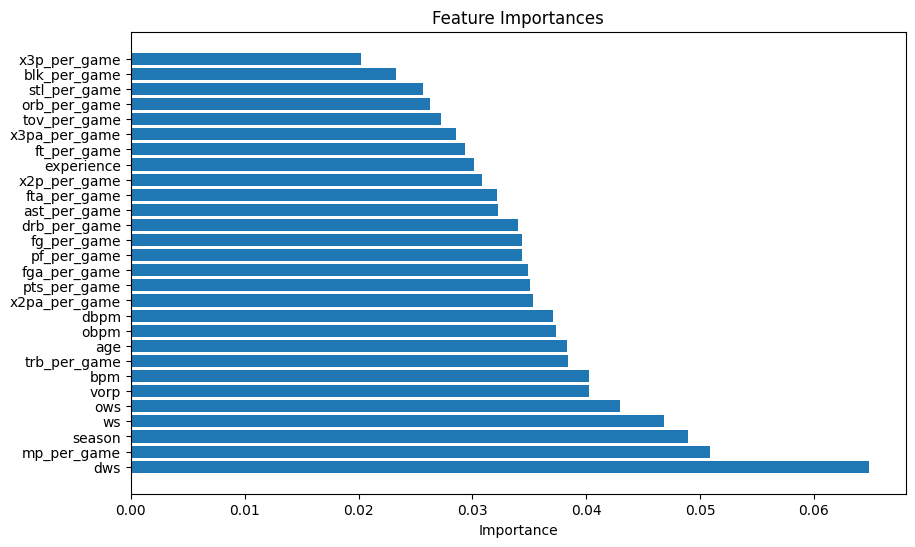

In [277]:
feature_names = injuries_bool.columns[:-1]
importances = rfc_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()

Plot injuries season-over-season

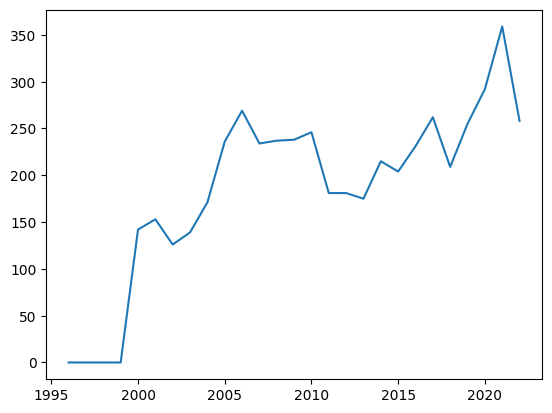

In [278]:
actual_injuries = injuries_bool[injuries_bool['injuries']==1]
actual_injuries = actual_injuries.reset_index(drop=True)
x = range(1996, 2023)
y = [0 for i in range(2022-1995)]
for i in range(len(actual_injuries['season'])):
    y[actual_injuries['season'][i]-1996]+=actual_injuries['injuries'][i]
plt.plot(x, y)
plt.show()

In [279]:
y

[0,
 0,
 0,
 0,
 142,
 153,
 126,
 139,
 171,
 236,
 269,
 234,
 237,
 238,
 246,
 181,
 181,
 175,
 215,
 204,
 231,
 262,
 209,
 255,
 292,
 359,
 258]

In [280]:
injuries_bool[(injuries_bool['season']==2019) & (injuries_bool['injuries']==1)]

,season,age,experience,mp_per_game,fg_per_game,fga_per_game,x3p_per_game,x3pa_per_game,x2p_per_game,x2pa_per_game,...,pf_per_game,pts_per_game,ows,dws,ws,obpm,dbpm,bpm,vorp,injuries
10868,2019,23.0,5,33.8,6.0,13.4,1.6,4.4,4.5,9.0,...,2.2,16.0,1.8,3.3,5.1,0.3,0.3,0.6,1.7,1
10870,2019,25.0,2,11.4,1.5,3.5,0.5,1.6,1.0,1.9,...,1.1,4.0,0.0,0.9,0.9,-3.6,0.3,-3.2,-0.2,1
10871,2019,32.0,12,29.0,5.7,10.6,1.1,3.0,4.6,7.6,...,1.9,13.6,4.5,2.9,7.5,3.3,1.9,5.1,3.6,1
10872,2019,28.0,9,28.3,3.2,7.3,1.2,3.5,2.0,3.9,...,1.8,9.4,3.0,2.8,5.8,0.1,0.6,0.7,1.5,1
10874,2019,27.0,8,21.5,3.0,7.4,1.0,2.6,2.0,4.8,...,1.4,8.8,0.7,0.8,1.5,-0.6,-0.7,-1.2,0.3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11560,2019,25.0,4,27.3,5.1,9.1,0.0,0.0,5.1,9.1,...,2.8,11.9,3.8,2.9,6.7,0.2,1.1,1.2,1.8,1
11562,2019,31.0,11,23.1,2.2,5.4,1.2,3.1,1.1,2.3,...,2.4,6.0,0.5,1.0,1.5,-2.3,-0.5,-2.8,-0.2,1
11568,2019,21.0,2,17.6,2.5,5.2,0.5,1.6,1.9,3.6,...,2.3,6.6,1.4,1.5,2.9,-1.5,0.3,-1.2,0.3,1
11569,2019,23.0,5,34.5,8.4,18.0,1.9,5.1,6.5,12.9,...,2.2,23.7,1.7,1.1,2.8,2.4,-1.6,0.8,1.5,1


In [310]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Prepare the dataset
# Replace 'target_column' with the actual name of your target variable
X = injuries_bool.drop('injuries', axis=1)  # Features
y = injuries_bool['injuries']  # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data into DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define XGBoost parameters for binary classification
params = {
    'objective': 'binary:logistic',  # Binary classification
    'max_depth': 6,
    'learning_rate': 0.08,
    'n_estimators': 100000,
    'colsample_bytree': 0.7,
    'eval_metric': 'logloss'  # Evaluation metric for binary classification
}

# Train the XGBoost model
model = xgb.train(params, dtrain, num_boost_round=100)

# Make predictions on the test set
y_pred = model.predict(dtest)

# Convert probabilities into 0 or 1 for binary classification
y_pred = [1 if x > 0.5 else 0 for x in y_pred]

# Evaluate the model using accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:53:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 70.53%


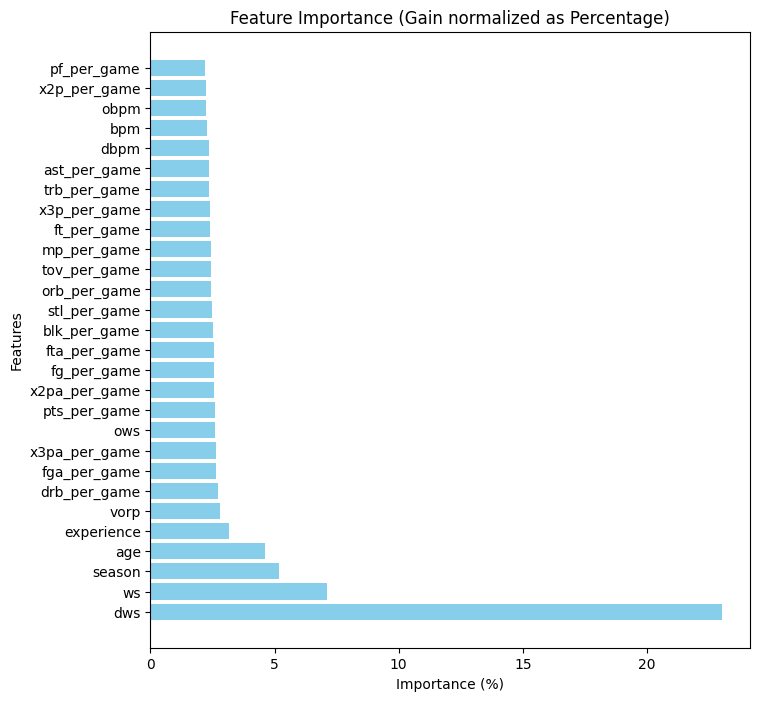

In [282]:
importance = model.get_score(importance_type='gain')

# Normalize the importance values to get percentages
total_gain = sum(importance.values())
importance_normalized = {k: (v / total_gain) * 100 for k, v in importance.items()}

# Sort the features by their importance (in descending order)
importance_normalized = dict(sorted(importance_normalized.items(), key=lambda x: x[1], reverse=True))

# Create a bar plot for normalized feature importance
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust the figure size for more spacing
ax.barh(list(importance_normalized.keys()), list(importance_normalized.values()), color='skyblue')

# Add labels and titles
ax.set_xlabel('Importance (%)')
ax.set_ylabel('Features')
ax.set_title('Feature Importance (Gain normalized as Percentage)')

# Customize the spacing between bars by adjusting the y-axis ticks
plt.subplots_adjust(left=0.3)  # Adjust the left margin to give more room for feature names

# Show the plot
plt.show()

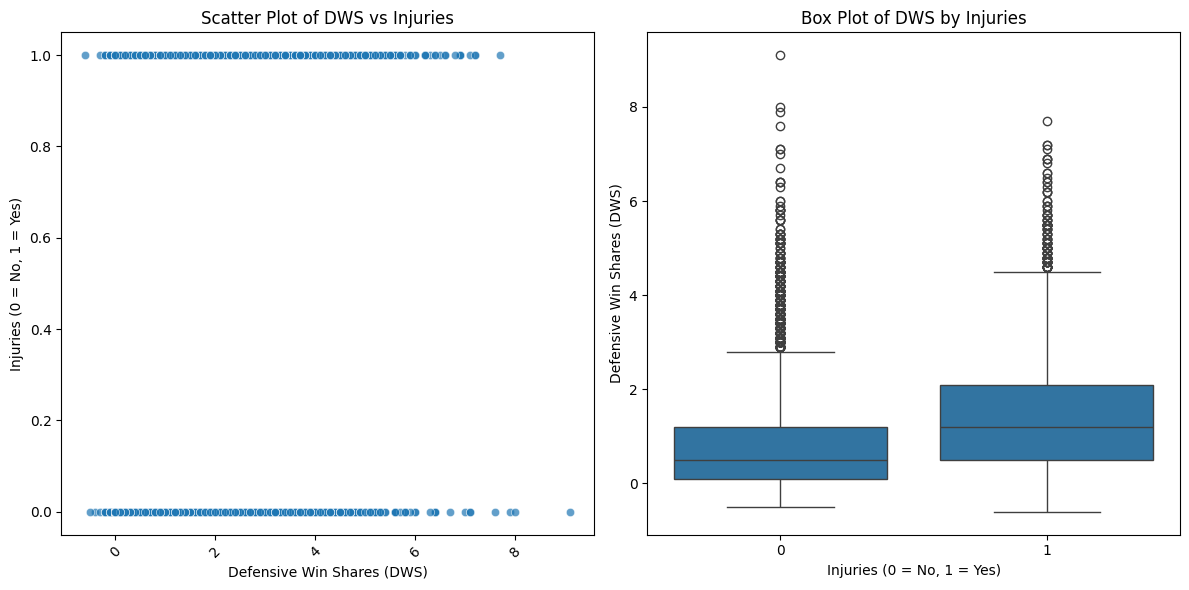

In [287]:
import seaborn as sns
# Scatter Plot
plt.figure(figsize=(12, 6))

# Scatter plot for DWS vs injuries
plt.subplot(1, 2, 1)
sns.scatterplot(data=injuries_bool, x='dws', y='injuries', alpha=0.7)
plt.title('Scatter Plot of DWS vs Injuries')
plt.xlabel('Defensive Win Shares (DWS)')
plt.ylabel('Injuries (0 = No, 1 = Yes)')
plt.xticks(rotation=45)

# Box Plot
plt.subplot(1, 2, 2)
sns.boxplot(data=injuries_bool, x='injuries', y='dws')
plt.title('Box Plot of DWS by Injuries')
plt.xlabel('Injuries (0 = No, 1 = Yes)')
plt.ylabel('Defensive Win Shares (DWS)')

plt.tight_layout()
plt.show()

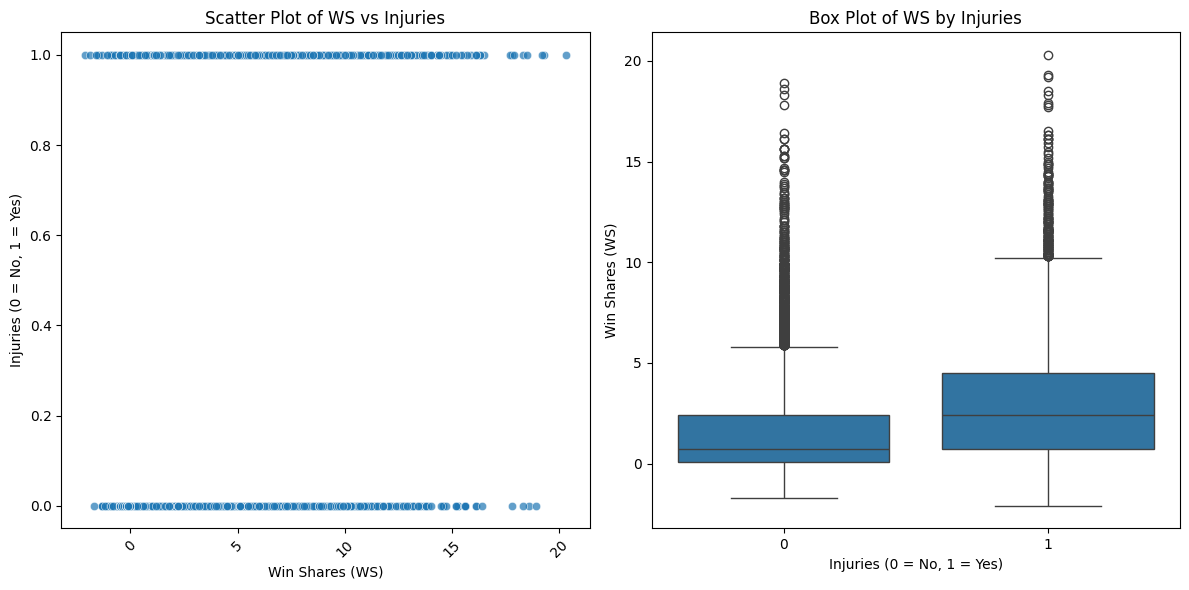

In [288]:
# Scatter Plot
plt.figure(figsize=(12, 6))

# Scatter plot for WS vs injuries
plt.subplot(1, 2, 1)
sns.scatterplot(data=injuries_bool, x='ws', y='injuries', alpha=0.7)
plt.title('Scatter Plot of WS vs Injuries')
plt.xlabel('Win Shares (WS)')
plt.ylabel('Injuries (0 = No, 1 = Yes)')
plt.xticks(rotation=45)

# Box Plot
plt.subplot(1, 2, 2)
sns.boxplot(data=injuries_bool, x='injuries', y='ws')
plt.title('Box Plot of WS by Injuries')
plt.xlabel('Injuries (0 = No, 1 = Yes)')
plt.ylabel('Win Shares (WS)')

plt.tight_layout()
plt.show()

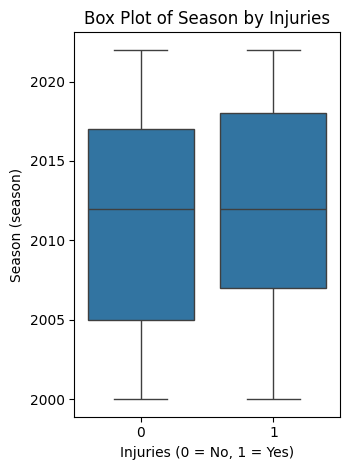

In [293]:
# Box Plot
plt.subplot(1, 2, 2)
sns.boxplot(data=injuries_bool, x='injuries', y='season')
plt.title('Box Plot of Season by Injuries')
plt.xlabel('Injuries (0 = No, 1 = Yes)')
plt.ylabel('Season (season)')

plt.tight_layout()
plt.show()

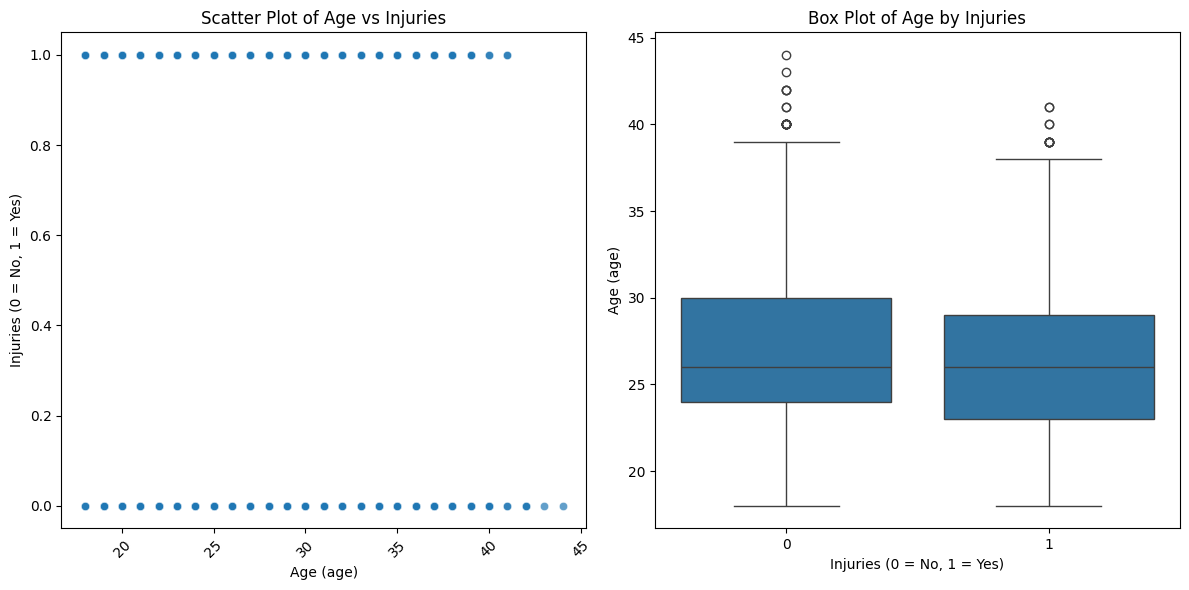

In [294]:
# Scatter Plot
plt.figure(figsize=(12, 6))

# Scatter plot for WS vs injuries
plt.subplot(1, 2, 1)
sns.scatterplot(data=injuries_bool, x='age', y='injuries', alpha=0.7)
plt.title('Scatter Plot of Age vs Injuries')
plt.xlabel('Age (age)')
plt.ylabel('Injuries (0 = No, 1 = Yes)')
plt.xticks(rotation=45)

# Box Plot
plt.subplot(1, 2, 2)
sns.boxplot(data=injuries_bool, x='injuries', y='age')
plt.title('Box Plot of Age by Injuries')
plt.xlabel('Injuries (0 = No, 1 = Yes)')
plt.ylabel('Age (age)')

plt.tight_layout()
plt.show()

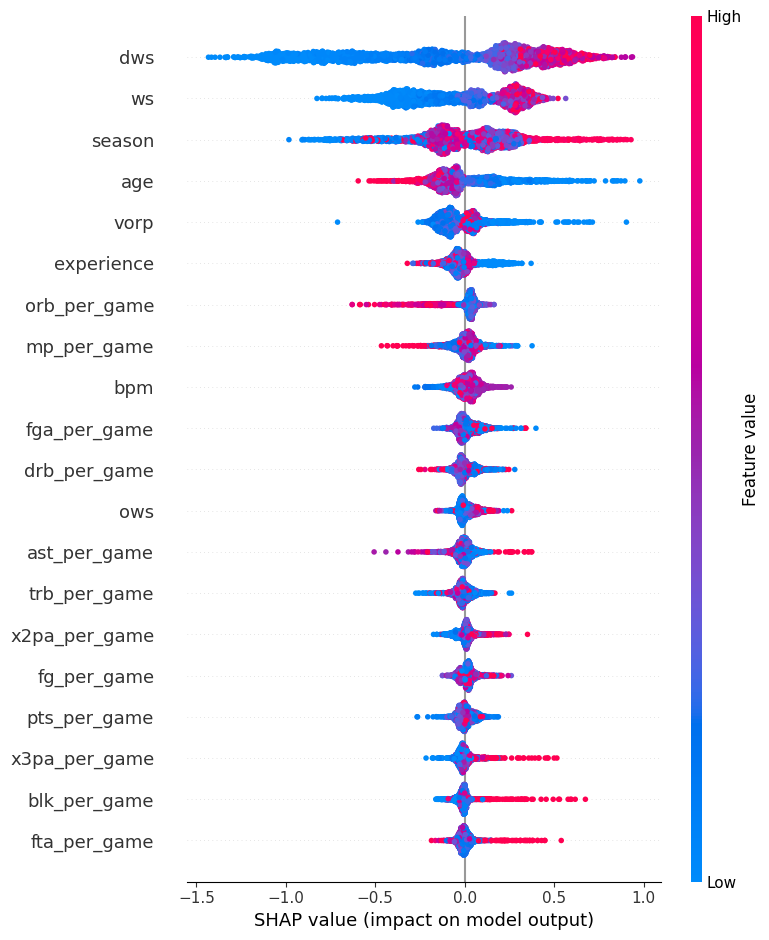

In [297]:
import shap
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for the test data
shap_values = explainer.shap_values(X_test)

# Visualize SHAP values (summary plot)
shap.summary_plot(shap_values, X_test)

In [309]:
from sklearn.metrics import precision_score, f1_score, accuracy_score, recall_score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')

Recall: 0.45
F1 Score: 0.53
Precision: 0.63


# **Association Rule Mining**

In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules

In [ ]:
injuries_bool

In [ ]:
arm = injuries_bool.copy()
for column in arm.columns:
  for i in range(len(arm)):
    if arm[column][i]>=arm[column].mean():
      arm[column][i] = 1
    else:
      arm[column][i] = 0


In [ ]:
arm

In [ ]:
arm_sets = apriori(arm, min_support = 0.1, use_colnames=True)

In [ ]:
arm_rules = association_rules(arm_sets, metric= 'lift', min_threshold = 1)

In [ ]:
arm_rules

In [ ]:
arm_result_injuries = arm_rules[arm_rules['consequents']==frozenset({'injuries'})]

In [ ]:
arm_result_injuries[(arm_result_injuries['confidence']>=0.5) & (arm_result_injuries['lift']>1.07)]

# **Adding Combine Stats**

In [ ]:
player_stats

In [ ]:
combine_stats = pd.read_csv('Draft_Combine.csv')

In [ ]:
combine_stats.head()

Transform each name into something without a string with first, last and without a comma

In [ ]:
for i in range(len(combine_stats)):
  commaindex = combine_stats['PLAYER'][i].find(',')
  combine_stats['PLAYER'][i] = combine_stats['PLAYER'][i][commaindex+2: ]+ " " +combine_stats['PLAYER'][i][:commaindex]

In [ ]:
combine_stats.head()

In [ ]:
player_stats_new = player_stats[~(player_stats['draft_year']=='Undrafted')]

In [ ]:
player_stats_new['draft_year'] = player_stats_new['draft_year'].astype(int)

In [ ]:
player_stats_new = player_stats_new[player_stats_new['draft_year']>=2000]

In [ ]:
player_stats_new.head()

In [ ]:
player_stats.columns

In [ ]:
combine_stats.columns

In [ ]:
combine_stats = combine_stats.drop(axis=1, columns = ['HEIGHT', 'WEIGHT'])

In [ ]:
player_stats_new = player_stats_new.reset_index(drop=True)

In [ ]:
player_with_combine = pd.concat([player_stats_new, combine_stats], axis=1)

In [ ]:
player_with_combine = player_with_combine.drop(axis = 1, columns = ['PLAYER','YEAR'])

In [ ]:
player_with_combine.columns

In [ ]:
combine_stats.columns

In [ ]:
combine_players = list(combine_stats['PLAYER'])

for i in range(len(player_with_combine)):
  try:
    ind = combine_players.index(player_with_combine['player_name'][i])
    for column in combine_stats.columns[2: ]:
      player_with_combine[column][i] = combine_stats[column][ind]
  except:
    player_with_combine['PDT'][i] = 'Missing'





In [ ]:
player_with_combine = player_with_combine[~(player_with_combine['PDT']=='Missing')]

In [ ]:
player_with_combine = player_with_combine.reset_index(drop=True)

In [ ]:
player_with_combine

Move injuries to end

In [ ]:
injuries_from_combine = player_with_combine['injuries']

In [ ]:
player_with_combine = player_with_combine.drop(columns = ['injuries'])

In [ ]:
player_with_combine['injuries'] = injuries_from_combine

In [ ]:
player_with_combine

Slides, update sent with papers/posters from Sloan, complete analysis on combine
Player tracking data to make something like a shot chart; folder with all objects related to this project

In [ ]:
player_with_combine.isnull().sum()

In [ ]:
player_with_combine = player_with_combine.drop(columns = ['HAND LENGTH', 'HAND WIDTH', 'SHUTTLE RUN', 'BENCH PRESS', 'PAN'])

In [ ]:
player_with_combine = player_with_combine.dropna()

In [ ]:
player_with_combine

In [ ]:
player_with_combine = player_with_combine.reset_index(drop=True)

In [ ]:
for i in range(len(player_with_combine['injuries'])):
  if len(player_with_combine['injuries'][i])>0:
    player_with_combine['injuries'][i] = 1
  else:
    player_with_combine['injuries'][i] = 0

In [ ]:
player_with_combine.dtypes

In [ ]:
player_with_combine["injuries"] = pd.to_numeric(player_with_combine["injuries"])

In [ ]:
player_with_combine.dtypes

In [ ]:
player_with_combine['POS'].unique()

In [ ]:
pos_dict = {'PG': 1, 'SG': 2, 'SF': 3, 'PF': 4, 'C': 5, 'SF/PF': 3, 'PF/C': 4, 'SG/SF': 2, 'PG/SG': 1}
for i in range(len(player_with_combine)):
  player_with_combine['POS'][i] = pos_dict[player_with_combine['POS'][i]]


In [ ]:
player_with_combine['POS'].head()

In [ ]:
player_with_combine['POS'] = pd.to_numeric(player_with_combine['POS'])

In [ ]:
player_with_combine = player_with_combine.select_dtypes('number')

In [ ]:
player_with_combine

In [ ]:
player_with_combine= player_with_combine.drop(columns = ['gp'])

In [ ]:
from sklearn.utils import shuffle
player_with_combine = shuffle(player_with_combine)
train_combine, valid_combine, test_combine = np.split(player_with_combine.sample(frac=1), [int(0.6*len(player_with_combine)), int(0.8*len(player_with_combine))])

In [ ]:
train_combine, x_train_combine, y_train_combine = scale(train_combine, oversample = False)

In [ ]:
valid_combine, x_valid_combine, y_valid_combine = scale(valid_combine, oversample = False)

In [ ]:
test_combine, x_test_combine, y_test_combine = scale(test_combine, oversample = False)

In [ ]:
pd.DataFrame(y_train_combine).dtypes

In [ ]:
nb_model = GaussianNB()
nb_model = nb_model.fit(x_train_combine, y_train_combine)
y_pred = nb_model.predict(x_test_combine)
print(classification_report(y_test_combine, y_pred))

In [ ]:
lg_model = LogisticRegression()
lg_model = lg_model.fit(x_train_combine, y_train_combine)
y_pred = lg_model.predict(x_test_combine)
print(classification_report(y_test_combine, y_pred))

In [ ]:
svm_model = SVC()
svm_model = svm_model.fit(x_train_combine, y_train_combine)
y_pred = svm_model.predict(x_test_combine)
print(classification_report(y_test_combine, y_pred))

In [ ]:
neighbors = 1
knn_model = KNeighborsClassifier(n_neighbors = neighbors)
knn_model.fit(x_train_combine, y_train_combine)
y_pred = knn_model.predict(x_test_combine)
print(classification_report(y_test_combine, y_pred))

In [ ]:
rfc_model = RandomForestClassifier(n_estimators=40)
rfc_model.fit(x_train_combine, y_train_combine)

In [ ]:
y_pred = rfc_model.predict(x_test_combine)
print(classification_report(y_test_combine, y_pred))

In [ ]:
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(x_train_combine, y_train_combine)

In [ ]:
y_pred = lda_model.predict(x_test_combine)
print(classification_report(y_test_combine, y_pred))

In [ ]:
feature_names = player_with_combine.columns[:-1]
importances = rfc_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split features and target (assuming last column is 'injuries')
X = player_with_combine.iloc[:, :-1].values  # Features (all columns except the last one)
y = player_with_combine.iloc[:, -1].values   # Target (injuries: 0 or 1)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Normalize the data (important for neural networks)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the fully connected neural network model
model = models.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.15,
                    callbacks=[lr_scheduler, early_stopping])

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc:.4f}')


In [ ]:
player_with_combine.columns

In [ ]:
age = player_with_combine[['usg_pct', 'injuries']]

In [ ]:
age

In [ ]:
train_age, valid_age, test_age = np.split(age.sample(frac=1), [int(0.6*len(age)), int(0.8*len(age))])

In [ ]:
train_age, x_train_age, y_train_age = scale(train_age, oversample = True)
valid_age, x_valid_age, y_valid_age = scale(valid_age, oversample = True)
test_age, x_test_age, y_test_age = scale(test_age, oversample = True)

In [ ]:
nb_model = GaussianNB()
nb_model = nb_model.fit(x_train_age, y_train_age)
y_pred = nb_model.predict(x_test_age)
print(classification_report(y_test_age, y_pred))

In [ ]:
lg_model = LogisticRegression()
lg_model = lg_model.fit(x_train_age, y_train_age)
y_pred = lg_model.predict(x_test_age)
print(classification_report(y_test_age, y_pred))

In [ ]:
rfc_model = RandomForestClassifier(n_estimators=40)
rfc_model.fit(x_train_age, y_train_age)
y_pred = rfc_model.predict(x_test_age)
print(classification_report(y_test_age, y_pred))

In [ ]:
!pip install xgboost

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Prepare the dataset
# Replace 'target_column' with the actual name of your target variable
X = player_with_combine.drop('injuries', axis=1)  # Features
y = player_with_combine['injuries']  # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data into DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define XGBoost parameters for binary classification
params = {
    'objective': 'binary:logistic',  # Binary classification
    'max_depth': 4,
    'learning_rate': 0.08,
    'n_estimators': 10000,
    'colsample_bytree': 0.7,
    'eval_metric': 'logloss'  # Evaluation metric for binary classification
}

# Train the XGBoost model
model = xgb.train(params, dtrain, num_boost_round=100)

# Make predictions on the test set
y_pred = model.predict(dtest)

# Convert probabilities into 0 or 1 for binary classification
y_pred = [1 if x > 0.5 else 0 for x in y_pred]

# Evaluate the model using accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")